In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min, norm, geom, uniform, lognorm
from scipy.linalg import toeplitz, solve
from itertools import product


# Utility functions

## Survival Curves


In [2]:
def normal_sf(n, loc=30, scale=10):
    """Compute the survival function (SF) of the normal distribution.

    Args:
        n: Number of integers to evaluate the SF at.
        loc: Mean of the normal distribution.
        scale: Standard deviation of the normal distribution.

    Returns:
        An array of the survival function (SF) values of the normal distribution
        evaluated at integers from 0 to n-1.
    """
    x = np.arange(n)
    return norm.sf(x, loc=loc, scale=scale)


def compute_survival_curve(kind, n, **kwargs):
    """Compute the survival function (SF) for a given statistical distribution

    Args:
        kind: The kind of distribution to use. Current options are:
            [fixed, weibull, normal, lognormal, geometric, uniform]
        n: The number of integers to evaluate the SF at.
        **kwargs: Additional distribution-specific parameters.

    Returns:
        An array of the survival function (SF) values of the specified distribution
        evaluated at integers from 0 to n-1.
    """
    survival_function = {
        "normal": normal_sf,
    }
    return survival_function[kind](n, **kwargs)


def compute_toeplitz_sf(arr):
    """Compute the (lower triangle) Toeplitz matrix of a survival curve.

    Args:
        arr: An array representing the survival curve.

    Returns:
        The Toeplitz matrix of the survival curve
    """
    n = len(arr)
    return toeplitz(arr) * np.tril(np.ones(shape=(n, n)))


def convert_to_df(time, survival_curve, cohort, inflow, outflow, stock, nas):
    """Convert the different (numpy) arrays representing a stock-flow model into DataFrames.

    Args:
        time: the time axis of the model.
        survival_curve: the survival curve used for the model.
        cohort: the cohort data of the model.
        inflow: the inflow data of the model.
        outflow: the outflow data of the model.
        stock: the stock data of the model.
        nas: The net addition to stock data of the model.

    Returns:
        A tuple containing two Pandas DataFrames:
        `timeseries` representing 5 vectors (survival curve, inflow, outflow, nas and stock)
            with time as index
        `cohort` matrix (time as both index and columns)
    """
    timeseries = pd.DataFrame(
        data={
            "survival_curve": survival_curve,
            "inflow": inflow,
            "outflow": outflow,
            "stock": stock,
            "nas": nas,
        },
        index=time,
    )
    cohort = pd.DataFrame(cohort, index=time, columns=time)
    return timeseries, cohort

## Stock Flow Model


In [3]:
def flow_driven_model(time, inflow, sf_kind="normal", stock_ini=0, **kwargs):
    """Computes a stock-flow model given inflow

    Args:
        time (np.ndarray): 1D array of time values
        inflow (np.ndarray): 1D array of inflow values
        sf_kind (str): Type of survival function used to compute the survival curve (default 'normal').
            Valid options are 'fixed', 'weibull', 'normal', 'geometric', 'uniform', and 'lognormal'.
        stock_ini (float): Initial stock value (default 0)
        **kwargs: Additional keyword arguments for the selected survival function

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two pandas DataFrames:
        - timeseries: A pandas DataFrame containing columns [survival_curve, inflow, outflow, stock, nas]
            and index as the given time array
        - cohort: A pandas DataFrame representing the cohort table, with rows and columns indexed by time.
            The values represent the number of individuals in the cohort at each time point.

    Raises:
        ValueError: If sf_kind is not a valid option
    """
    survival_curve = compute_survival_curve(kind=sf_kind, n=len(time), **kwargs)
    survival_toeplitz = compute_toeplitz_sf(survival_curve)
    cohort = inflow * survival_toeplitz
    stock = cohort.sum(axis=1)  # EXTRA STEP COMPARED WITH STOCK-DRIVEN
    nas = np.diff(stock, prepend=stock_ini)
    outflow = inflow - nas
    timeseries, cohort = convert_to_df(
        time, survival_curve, cohort, inflow, outflow, stock, nas
    )
    return timeseries, cohort


<hr>

# Question 1

Choose one material in one of the countries, change one of the four input variables, one at a time by +10% and then by -10% while holding the other 3 inputs constant at their original values (ceteris paribus). Record the resulting inflows, outflows, and stocks, and repeat this for the other 3 input variables

Parameters are:

- Inflows. (Adjust the entire time series by ±10%)
- The survival curve’s mean parameter
- The survival curve’s standard deviation parameter
- The percent of DMC that goes into construction stocks ($\text{inflow} = \text{DMC} \times \text{percent to construction}$)


In [9]:
# Load the data

FILE_PATH = "../../data/stock_of_nations2014.xlsx"


def get_data(path, country, material):
    sheet_param = "material_parameters"
    sheet_data = "direct_material_consumption"
    param = pd.read_excel(path, sheet_name=sheet_param, header=0, index_col=0).loc[
        material
    ]
    data = pd.read_excel(path, sheet_name=sheet_data, header=[0, 1], index_col=0).loc[
        :, (country, material)
    ]
    return data, param


def generate_scenarios(data, avg, stdev, mat_intensity, change=0.1):
    # Run the model under both conditions
    scenarios = {
        "baseline": (data, avg, stdev, mat_intensity),
        "inflows+10%": ((1 + change) * data, avg, stdev, mat_intensity),
        "inflows-10%": ((1 - change) * data, avg, stdev, mat_intensity),
        "mean+10%": (data, (1 + change) * avg, stdev, mat_intensity),
        "mean-10%": (data, (1 - change) * avg, stdev, mat_intensity),
        "stedv+10%": (data, avg, (1 + change) * stdev, mat_intensity),
        "stedv-10%": (data, avg, (1 - change) * stdev, mat_intensity),
        "intensity+10%": (data, avg, stdev, (1 + change) * mat_intensity),
        "intensity-10%": (data, avg, stdev, (1 - change) * mat_intensity),
    }
    return scenarios


def display_timeseries(timeseries, indicators):
    # Display results
    fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharey=False)

    for i, column in enumerate(indicators):
        for label, series in timeseries.items():
            sns.lineplot(
                series[column], ax=ax[i // 2, i % 2], label=label, legend=False
            )
            ax[i // 2, i % 2].set_title(f"{column}")

    handles, labels = ax[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3)
    fig.show()
    # return fig


def run_simulations(path, country, material, indicators):
    # get data
    data, param = get_data(path, country, material)
    year = data.index.values
    prod_flow = data.values

    # Make up scenarios
    scenarios = generate_scenarios(prod_flow, *param)

    # run the model with above parameters
    timeseries, cohort = dict(), dict()
    for scenario, param in scenarios.items():
        flow, avg, stdev, mi = param
        inflow = flow * mi
        timeseries[scenario], cohort[scenario] = flow_driven_model(
            time=year, inflow=inflow, sf_kind="normal", loc=avg, scale=stdev
        )

    return display_timeseries(timeseries, indicators)

/tmp/ipykernel_71117/2374525687.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


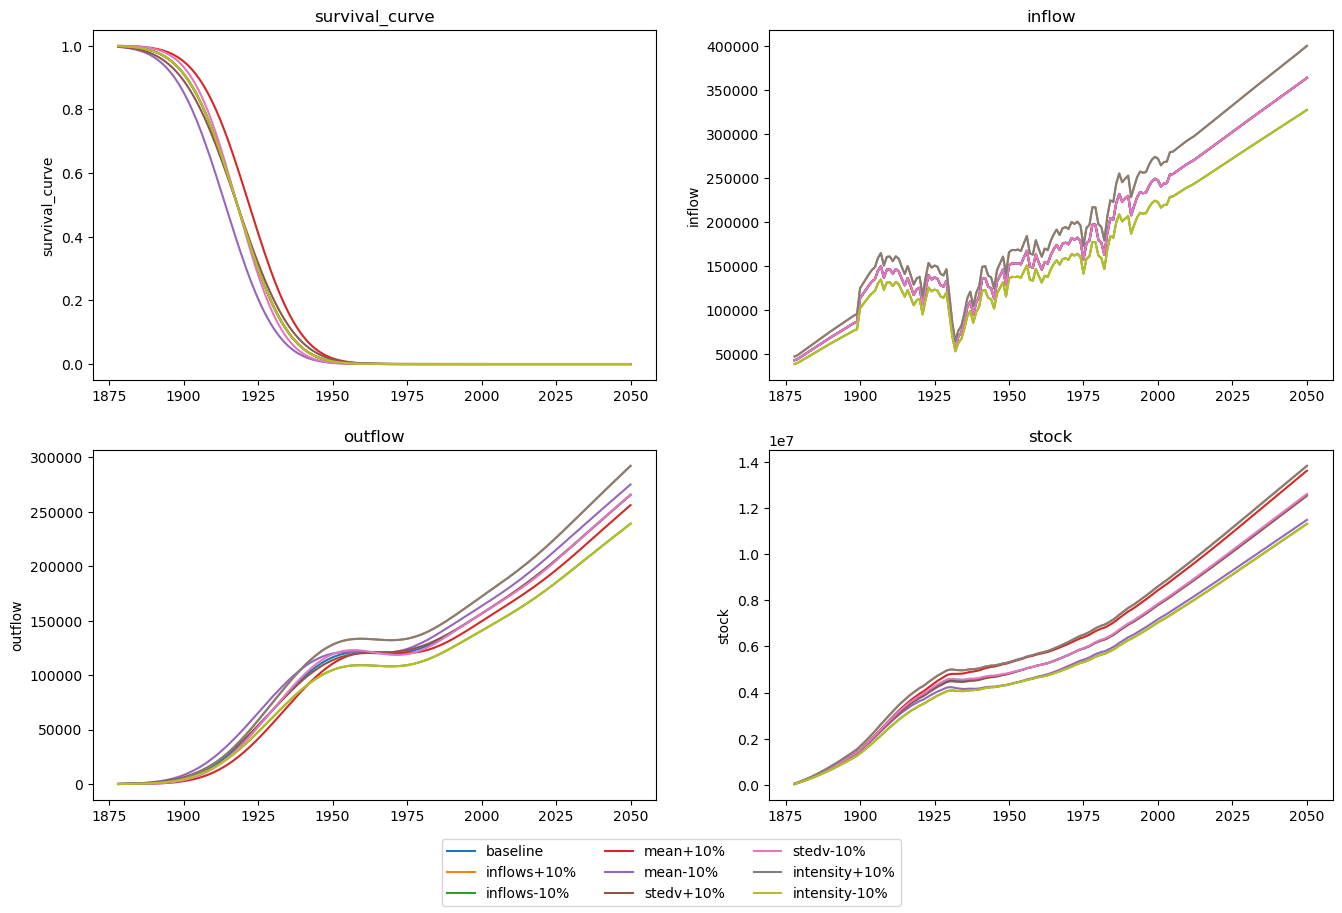

In [10]:
FILE_PATH = "../../data/stock_of_nations2014.xlsx"
country = "USA"
material = "timber"
indicators = ["survival_curve", "inflow", "outflow", "stock"]

run_simulations(FILE_PATH, country, material, indicators)


/tmp/ipykernel_71117/2374525687.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


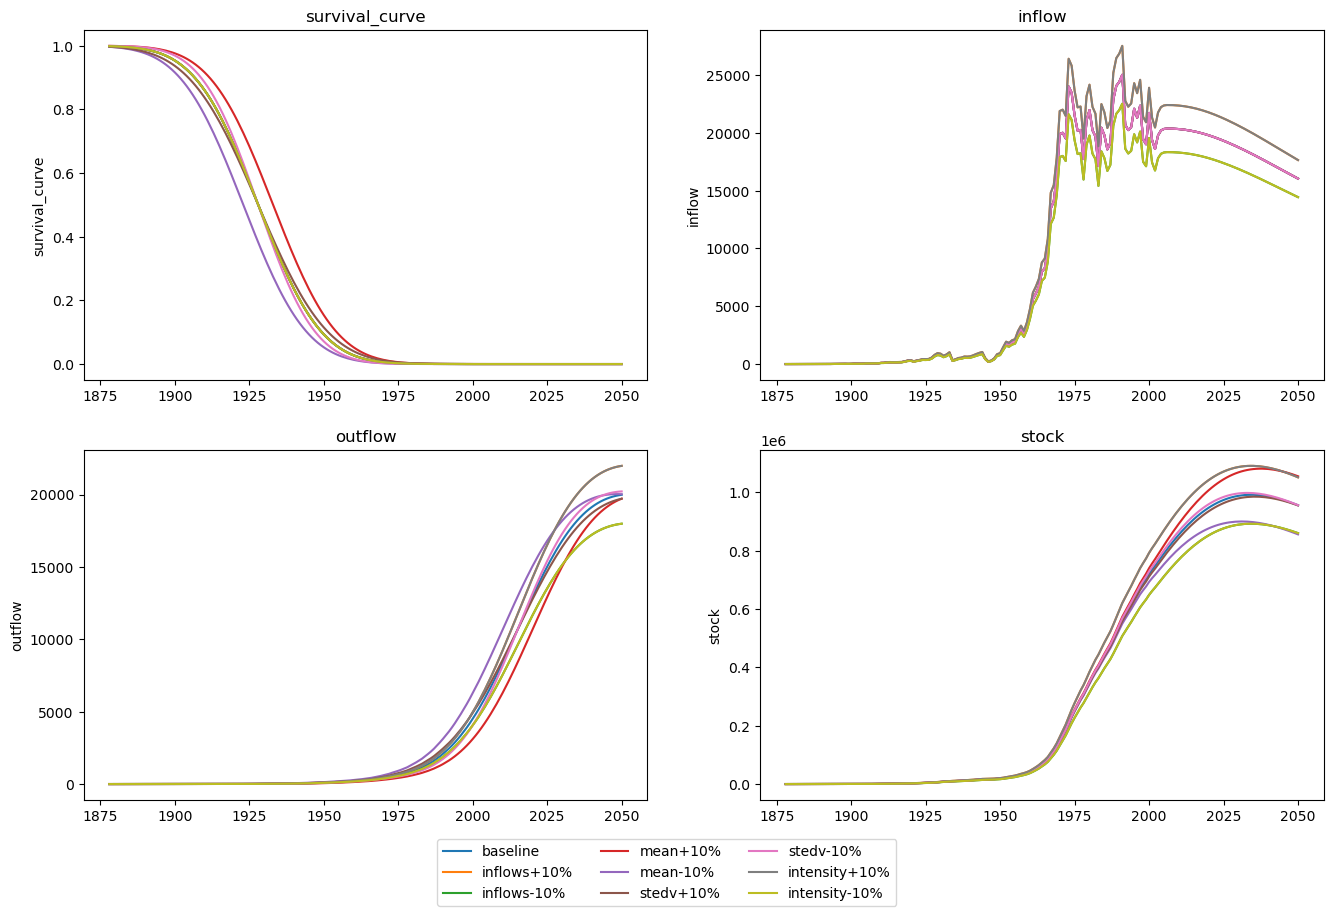

In [11]:
country = "Japan"
material = "iron"

run_simulations(FILE_PATH, country, material, indicators)